In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('data/reg.csv', index_col=[0])

df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,Price
0,0.034633,0.206919,0.137057,0.540526,0.193941,0.699239,0.630532,0.239410,0.027375,0.209857,0.347609,0.996394,0.102644,0.422222
1,0.028920,0.014315,0.276113,0.255945,0.618886,0.555407,0.782263,0.482977,0.103031,0.106690,0.520776,0.996650,0.187120,0.368889
2,0.020627,0.033230,0.281116,0.525591,0.165269,0.624102,0.586005,0.272713,0.036010,0.106986,0.595301,0.983284,0.084079,0.660000
3,0.022749,0.033801,0.125044,0.263253,0.251509,0.658532,0.432160,0.344932,0.150018,0.068317,0.651297,0.989989,0.015990,0.631111
4,0.022148,0.029374,0.121057,0.521126,0.399670,0.448086,0.520158,0.495342,0.104383,0.069360,0.560116,0.998723,0.092782,0.693333


In [10]:
X = df.drop('Price', axis=1).to_numpy()
y = df['Price'].to_numpy().reshape((-1, 1))

X.shape, y.shape 

((506, 13), (506, 1))

In [11]:
class TensorDataset(Dataset):
    def __init__(self, x, y) -> None:
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [13]:
train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [15]:
class Regressor(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        return x

In [17]:
model = Regressor()
criterion = nn.MSELoss()

In [5]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [18]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [19]:
loss_ = []
n = len(train_loader)
epochs = 400

for epoch in range(epochs):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader):
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_.append(running_loss/n)
    scheduler.step()

print('finished training')

finished training


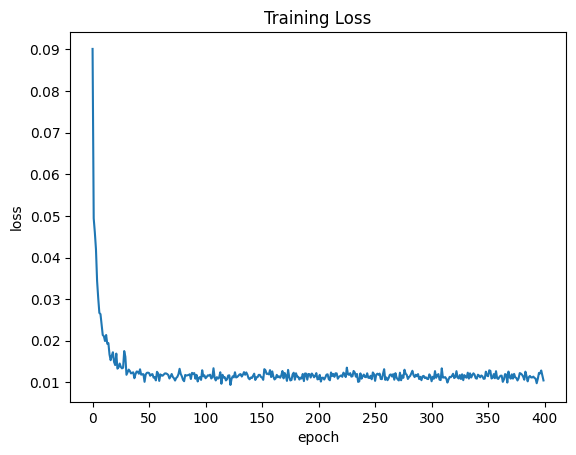

In [20]:
plt.plot(loss_)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [21]:
def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)

    with torch.inference_mode():
        model.eval()
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)

    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

In [22]:
train_rmse = evaluation(train_loader)
test_rmse = evaluation(test_loader)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 0.09892905
Test RMSE: 0.10632222
